<a href="https://colab.research.google.com/github/Vladm0z/HSE-Bioinformatics/blob/main/Bioinformatics/MSc/SequenceDA/NGS_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task**

1.
- Quality Control with FastQC
  -	Run FastQC on the raw FASTQ files (sample_R1.fastq.gz, sample_R2.fastq.gz).
  -	Examine the HTML reports to check:
  -	Per-base sequence quality.
  -	Adapter contamination.
  -	GC content distribution.
- Question:
  - Based on the FastQC report, what are the main quality issues in the raw reads?

2.
- Read Trimming (Optional but Recommended)
  -	Use Trimmomatic or FastP to remove adapters and low-quality bases.
  -	Compare the trimmed FASTQ files with the original ones. Use multiQC if applicable,
- Question:
  - How many reads were discarded during trimming? Did the overall quality improve?

3.
- Alignment to the Human Reference Genome (GRCh38)
  -	Index the reference genome (GRCh38.fa) using bwa index.
  -	Align the trimmed reads using bwa mem.
  -	Convert the output SAM file to a sorted BAM file (aligned_sorted.bam).
- Question:
  - What percentage of reads successfully aligned to the genome? (Use samtools flagstat.)

4.
- BAM File Processing & Analysis
  -	Mark PCR duplicates using samtools markdup.
  -	Calculate read coverage (samtools depth).
  -	(Optional) Perform variant calling (bcftools mpileup).

- Questions:
  -	Why is it important to mark PCR duplicates before variant calling?
  -	What regions of the genome have the highest/lowest coverage?

Expected Deliverables
  -	FastQC reports (raw and trimmed, if applicable).
  -	Trimmed FASTQ files (if trimming was performed).
  -	Sorted & indexed BAM file (aligned_sorted.bam).
  -	Coverage file (coverage.txt).
  -	(Optional) VCF file (variants.vcf) with potential variants.

Discussion & Critical Thinking Questions
- Data Quality:
  -	How did the FastQC results influence your decision to trim reads?
  -	Would you trust variant calls made from low-quality regions? Why or why not?
- Alignment & Duplicates:
  -	If only 60% of reads aligned, what could be possible reasons?
  -	How do PCR duplicates affect downstream analysis?


# **Bioinformatics Homework: NGS Data Analysis Pipeline**
**Objective**: Analyze paired-end FASTQ files, align to human genome (GRCh38), and process BAM files.

In [1]:
# Install tools
!apt-get update
!apt-get install fastqc trimmomatic bwa samtools bcftools -y
!pip install biopython

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,607 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,696 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4,118 kB]
Get:13 http://archiv

In [2]:
!pip install multiqc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.9 MB/s eta 0:00:00


In [3]:
# Download data (1000 Genomes Project)
!wget https://ftp-trace.ncbi.nih.gov/1000genomes/ftp/phase3/data/NA12878/sequence_read/ERR003983_1.filt.fastq.gz  # Replace with Your data
!wget https://ftp-trace.ncbi.nih.gov/1000genomes/ftp/phase3/data/NA12878/sequence_read/ERR003983_2.filt.fastq.gz
!wget ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/001/405/GCA_000001405.15_GRCh38/seqs_for_alignment_pipelines.ucsc_ids/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz -O GRCh38.fa.gz
!gunzip GRCh38.fa.gz

--2025-04-25 07:24:06--  https://ftp-trace.ncbi.nih.gov/1000genomes/ftp/phase3/data/NA12878/sequence_read/ERR003983_1.filt.fastq.gz
Resolving ftp-trace.ncbi.nih.gov (ftp-trace.ncbi.nih.gov)... 130.14.250.31, 130.14.250.7, 2607:f220:41e:250::10, ...
Connecting to ftp-trace.ncbi.nih.gov (ftp-trace.ncbi.nih.gov)|130.14.250.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1449192535 (1.3G) [application/x-gzip]
Saving to: ‘ERR003983_1.filt.fastq.gz’

ERR003983_1.filt.fa 100%[===================>]   1.35G  11.2MB/s    in 2m 2s   

2025-04-25 07:26:09 (11.3 MB/s) - ‘ERR003983_1.filt.fastq.gz’ saved [1449192535/1449192535]

--2025-04-25 07:26:09--  https://ftp-trace.ncbi.nih.gov/1000genomes/ftp/phase3/data/NA12878/sequence_read/ERR003983_2.filt.fastq.gz
Resolving ftp-trace.ncbi.nih.gov (ftp-trace.ncbi.nih.gov)... 130.14.250.7, 130.14.250.10, 2607:f220:41e:250::7, ...
Connecting to ftp-trace.ncbi.nih.gov (ftp-trace.ncbi.nih.gov)|130.14.250.7|:443... connected.
HTTP r

In [4]:
# Verify installations
!fastqc --version
!bwa
!samtools --version
!java -jar /usr/share/java/trimmomatic-0.39.jar -version

FastQC v0.11.9

Program: bwa (alignment via Burrows-Wheeler transformation)
Version: 0.7.17-r1188
Contact: Heng Li <lh3@sanger.ac.uk>

Usage:   bwa <command> [options]

Command: index         index sequences in the FASTA format
         mem           BWA-MEM algorithm
         fastmap       identify super-maximal exact matches
         pemerge       merge overlapping paired ends (EXPERIMENTAL)
         aln           gapped/ungapped alignment
         samse         generate alignment (single ended)
         sampe         generate alignment (paired ended)
         bwasw         BWA-SW for long queries

         shm           manage indices in shared memory
         fa2pac        convert FASTA to PAC format
         pac2bwt       generate BWT from PAC
         pac2bwtgen    alternative algorithm for generating BWT
         bwtupdate     update .bwt to the new format
         bwt2sa        generate SA from BWT and Occ

Note: To use BWA, you need to first index the genome with `bwa index'.


[YaDisk](https://disk.yandex.ru/i/SrCF0L1GGjk7pg)

[1000 genomes](https://ftp-trace.ncbi.nih.gov/1000genomes/ftp/phase3/data/NA12878/sequence_read/)

## **Quality Control with FastQC**

In [5]:
!fastqc -t 4 ERR003983_1.filt.fastq.gz ERR003983_2.filt.fastq.gz

Started analysis of ERR003983_1.filt.fastq.gz
Started analysis of ERR003983_2.filt.fastq.gz
Approx 5% complete for ERR003983_2.filt.fastq.gz
Approx 5% complete for ERR003983_1.filt.fastq.gz
Approx 10% complete for ERR003983_2.filt.fastq.gz
Approx 10% complete for ERR003983_1.filt.fastq.gz
Approx 15% complete for ERR003983_1.filt.fastq.gz
Approx 15% complete for ERR003983_2.filt.fastq.gz
Approx 20% complete for ERR003983_1.filt.fastq.gz
Approx 20% complete for ERR003983_2.filt.fastq.gz
Approx 25% complete for ERR003983_1.filt.fastq.gz
Approx 25% complete for ERR003983_2.filt.fastq.gz
Approx 30% complete for ERR003983_1.filt.fastq.gz
Approx 30% complete for ERR003983_2.filt.fastq.gz
Approx 35% complete for ERR003983_1.filt.fastq.gz
Approx 35% complete for ERR003983_2.filt.fastq.gz
Approx 40% complete for ERR003983_2.filt.fastq.gz
Approx 40% complete for ERR003983_1.filt.fastq.gz
Approx 45% complete for ERR003983_1.filt.fastq.gz
Approx 45% complete for ERR003983_2.filt.fastq.gz
Approx 50%

In [6]:
!multiqc .


/// ]8;id=551324;https://multiqc.info\MultiQC]8;;\ 🔍 v1.28

       file_search | Search path: /content
         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 28/28  
            fastqc | Found 2 reports
            violin | Tried to make table/violin plot, but had no data. pconfig: {'namespace': 'FastQC', 'id': 'fastqc_top_overrepresented_sequences_table', 'title': 'FastQC: Top overrepresented sequences', 'col1_header': 'Overrepresented sequence', 'sort_rows': False}
     write_results | Data        : multiqc_data
     write_results | Report      : multiqc_report.html
           multiqc | MultiQC complete


In [7]:
from google.colab import files
files.download('ERR003983_1.filt_fastqc.html')
files.download('ERR003983_2.filt_fastqc.html')
files.download('multiqc_report.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Reports

In [ ]:
import base64
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
from IPython.display import display, HTML

def parse_fastqc_html(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')

    # Extract summary information
    summary = {}
    summary_section = soup.find('div', class_='summary')
    for item in summary_section.find_all('li'):
        status = item.img['alt'].strip('[]')
        module = item.a.text
        summary[module] = status

    # Extract detailed information from modules
    modules = {}
    for module_div in soup.find_all('div', class_='module'):
        module_name = module_div.h2.text.strip()
        content = {}

        # Extract status
        status_img = module_div.find('img')
        if status_img:
            content['status'] = status_img['alt'].strip('[]')

        # Extract tables
        table = module_div.find('table')
        if table:
            headers = [th.text for th in table.find_all('th')]
            rows = []
            for tr in table.find_all('tr'):
                rows.append([td.text for td in tr.find_all('td')])
            df = pd.DataFrame(rows[1:], columns=headers)
            content['table'] = df

        # Extract images
        img = module_div.find('img', class_='indented')
        if img:
            img_data = img['src'].split('base64,')[1]
            content['image'] = base64.b64decode(img_data)

        modules[module_name] = content

    return summary, modules

def display_report(summary, modules, filename):
    print(f"{filename}")
    print("="*80)
    # Display summary
    display(pd.DataFrame.from_dict(summary, orient='index', columns=['Status']))

    # Display detailed modules
    for module_name, content in modules.items():
        print(f"\n{module_name}")
        if 'status' in content:
            print(f"Status: {content['status']}")

        if 'table' in content:
            display(content['table'])

        if 'image' in content:
            img = plt.imread(BytesIO(content['image']))
            plt.figure(figsize=(10, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.show()

ERR003983_1.filt_fastqc.html


,Status
Basic Statistics,PASS
Per base sequence quality,WARNING
Per tile sequence quality,PASS
Per sequence quality scores,WARNING
Per base sequence content,WARNING
Per sequence GC content,WARNING
Per base N content,PASS
Sequence Length Distribution,PASS
Sequence Duplication Levels,PASS
Overrepresented sequences,PASS



Basic Statistics
Status: OK


,Measure,Value
0,Filename,ERR003983_1.filt.fastq.gz
1,File type,Conventional base calls
2,Encoding,Sanger / Illumina 1.9
3,Total Sequences,18531842
4,Sequences flagged as poor quality,0
5,Sequence length,76
6,%GC,44



Per base sequence quality
Status: WARN


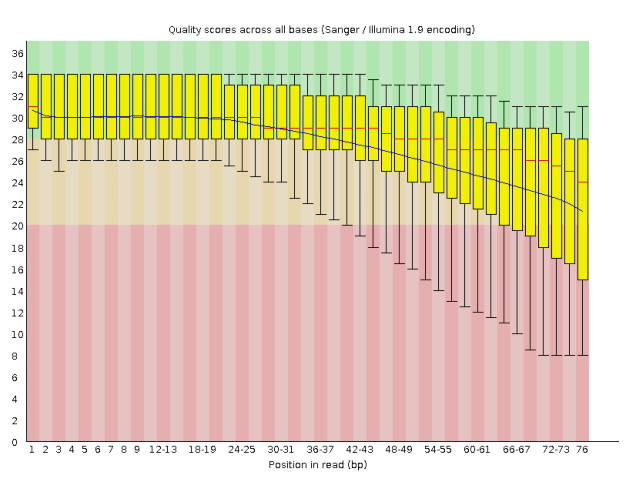


Per tile sequence quality
Status: OK


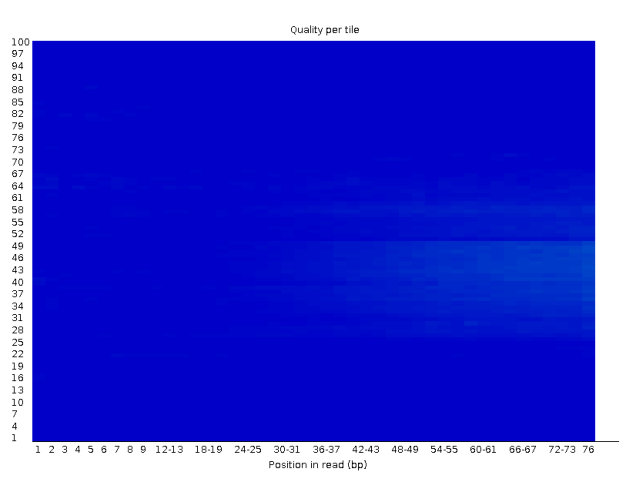


Per sequence quality scores
Status: WARN


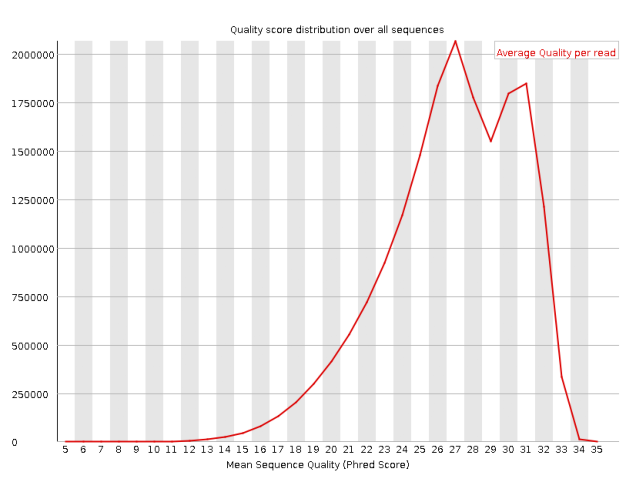


Per base sequence content
Status: WARN


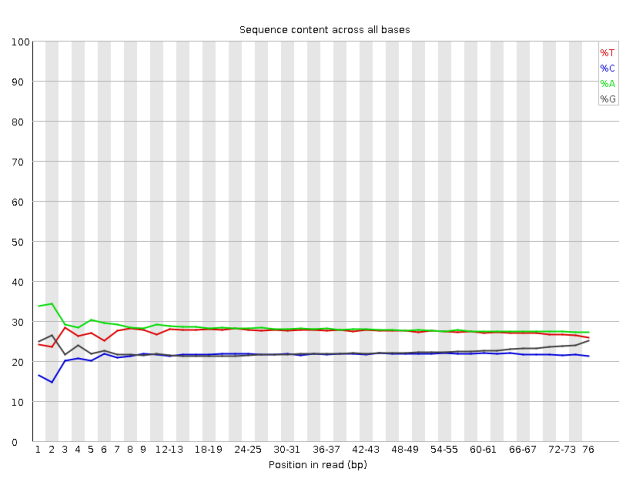


Per sequence GC content
Status: WARN


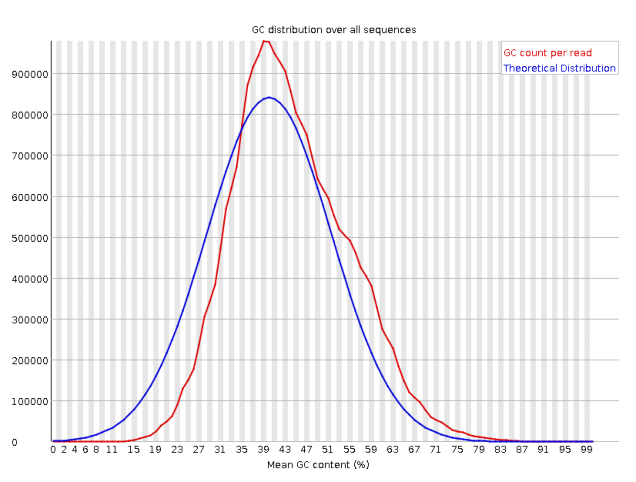


Per base N content
Status: OK


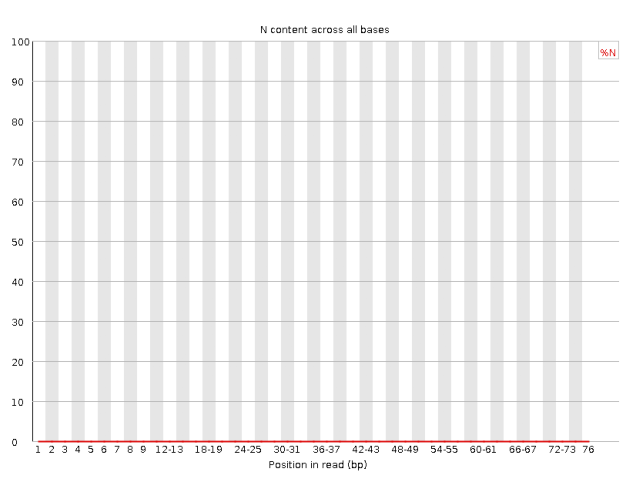


Sequence Length Distribution
Status: OK


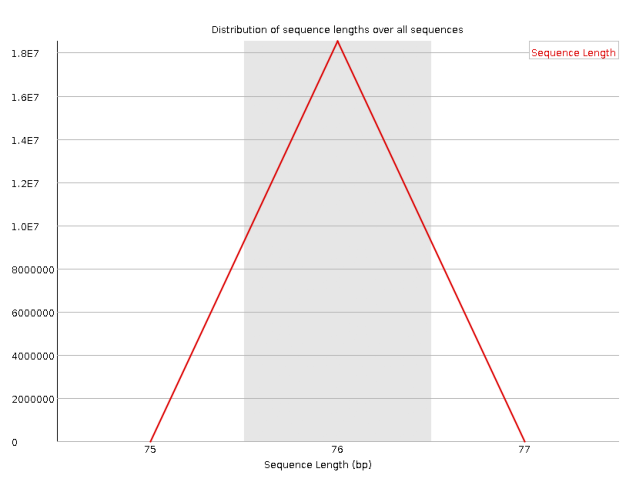


Sequence Duplication Levels
Status: OK


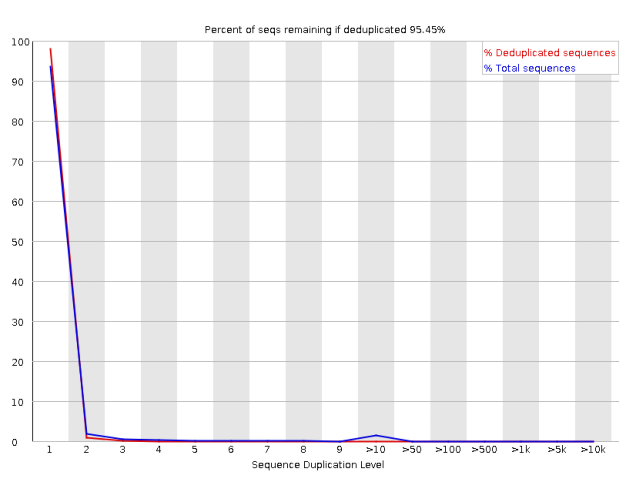


Overrepresented sequences
Status: OK

Adapter Content
Status: OK


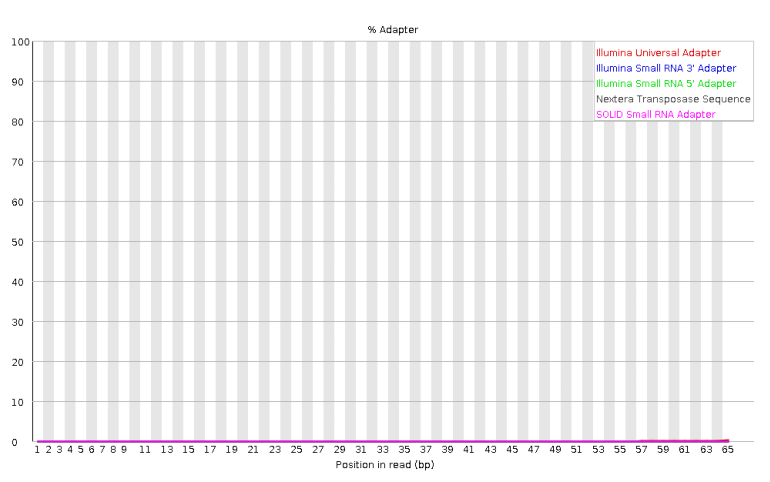

ERR003983_2.filt_fastqc.html


,Status
Basic Statistics,PASS
Per base sequence quality,WARNING
Per tile sequence quality,PASS
Per sequence quality scores,WARNING
Per base sequence content,PASS
Per sequence GC content,WARNING
Per base N content,PASS
Sequence Length Distribution,PASS
Sequence Duplication Levels,PASS
Overrepresented sequences,PASS



Basic Statistics
Status: OK


,Measure,Value
0,Filename,ERR003983_2.filt.fastq.gz
1,File type,Conventional base calls
2,Encoding,Sanger / Illumina 1.9
3,Total Sequences,18531842
4,Sequences flagged as poor quality,0
5,Sequence length,76
6,%GC,44



Per base sequence quality
Status: WARN


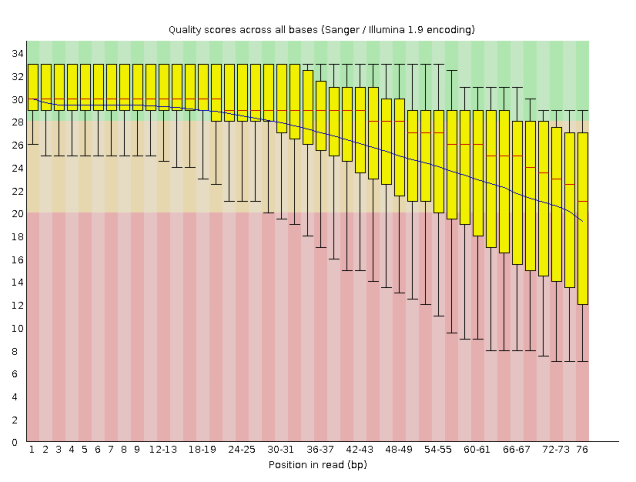


Per tile sequence quality
Status: OK


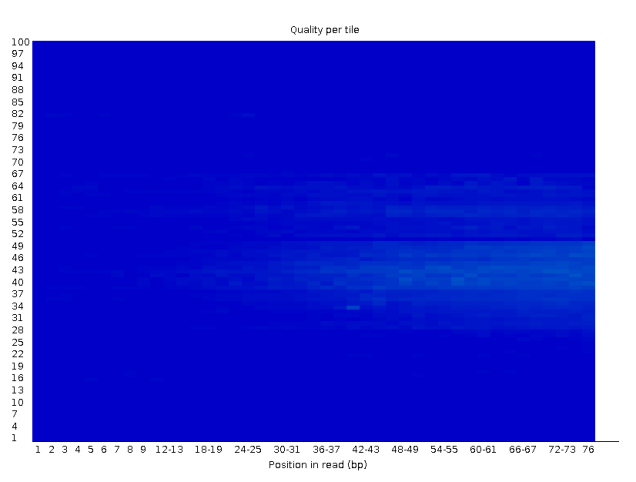


Per sequence quality scores
Status: WARN


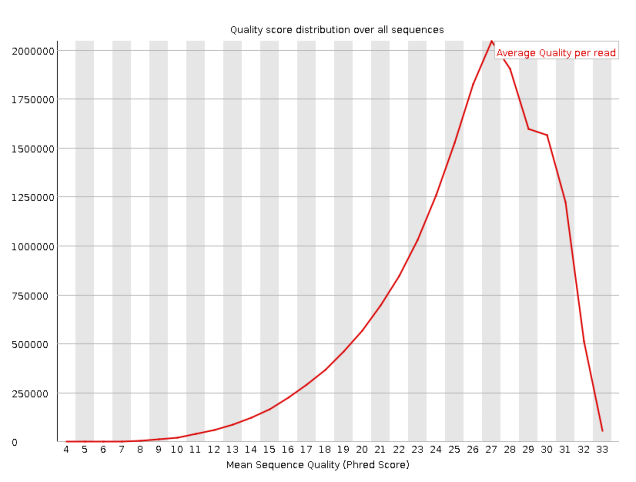


Per base sequence content
Status: OK


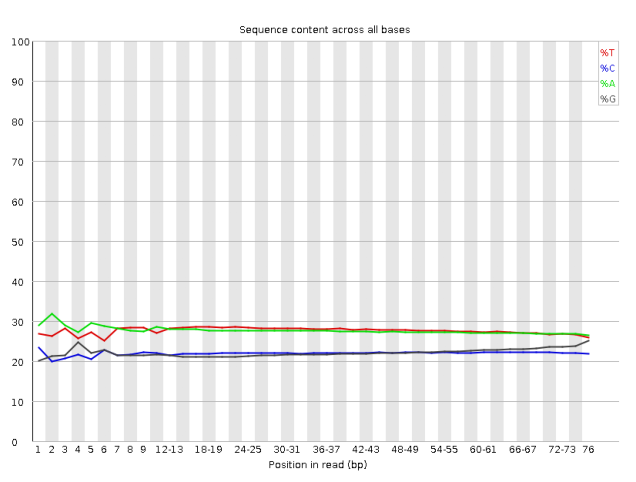


Per sequence GC content
Status: WARN


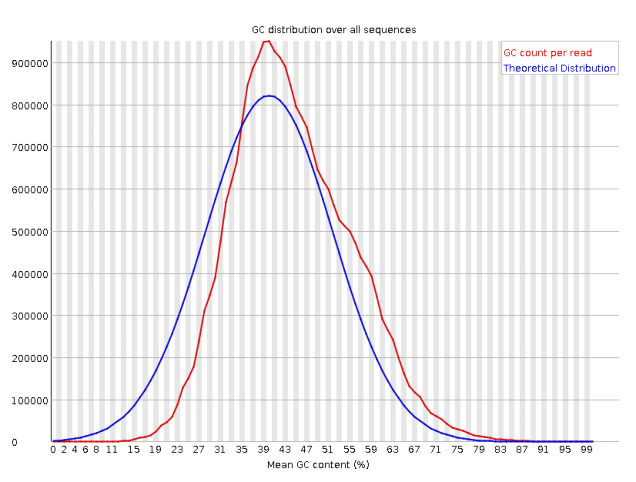


Per base N content
Status: OK


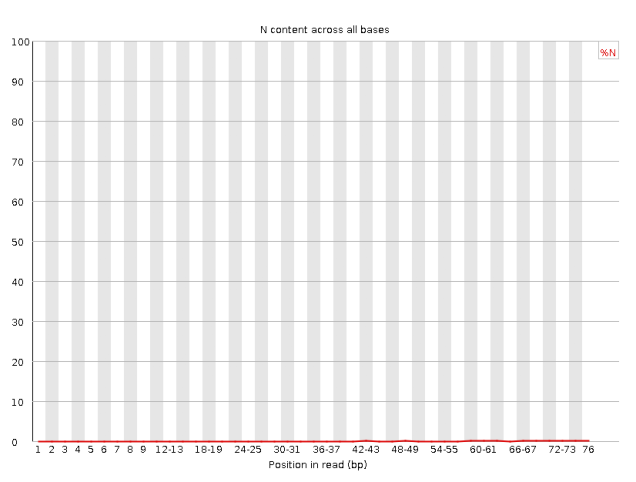


Sequence Length Distribution
Status: OK


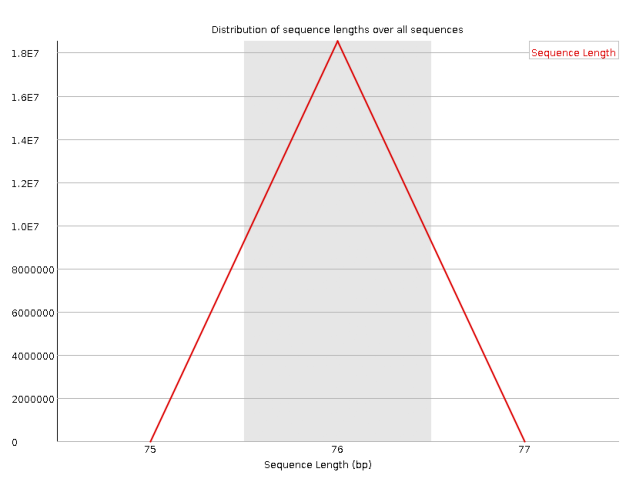


Sequence Duplication Levels
Status: OK


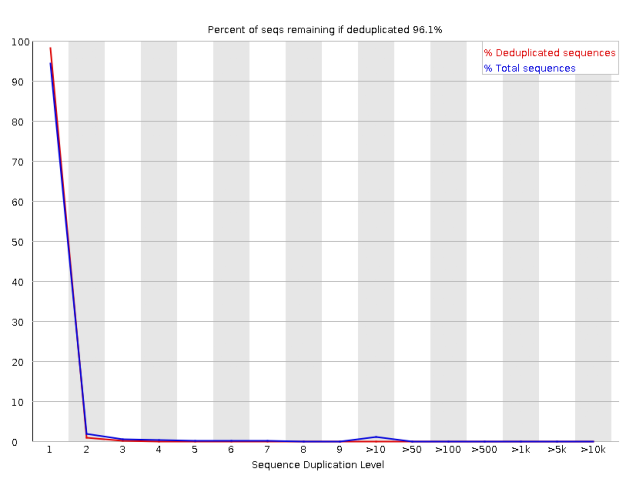


Overrepresented sequences
Status: OK

Adapter Content
Status: OK


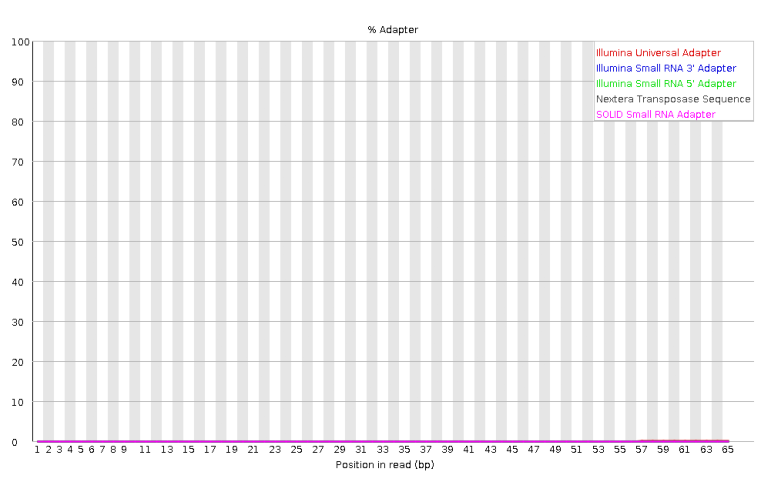

multiqc_report.html: 'NoneType' object has no attribute 'find_all'


In [ ]:
filenames = [
    'ERR003983_1.filt_fastqc.html',
    'ERR003983_2.filt_fastqc.html',
    'multiqc_report.html'
]
for filename in filenames:
    try:
        with open(filename, 'r') as f:
            html_content = f.read()

        summary, modules = parse_fastqc_html(html_content)
        display_report(summary, modules, filename)

    except Exception as e:
        print(f"{filename}: {str(e)}")

## **Read Trimming and Filtering**

In [8]:
# Paired-end trimming
!java -jar /usr/share/java/trimmomatic-0.39.jar PE -threads 4 \
    ERR003983_1.filt.fastq.gz ERR003983_2.filt.fastq.gz \
    ERR003983_R1.trimmed.fastq.gz ERR003983_R1.unpaired.fastq.gz \
    ERR003983_R2.trimmed.fastq.gz ERR003983_R2.unpaired.fastq.gz \
    ILLUMINACLIP:TruSeq3-PE.fa:2:30:10 SLIDINGWINDOW:4:20 MINLEN:50

TrimmomaticPE: Started with arguments:
 -threads 4 ERR003983_1.filt.fastq.gz ERR003983_2.filt.fastq.gz ERR003983_R1.trimmed.fastq.gz ERR003983_R1.unpaired.fastq.gz ERR003983_R2.trimmed.fastq.gz ERR003983_R2.unpaired.fastq.gz ILLUMINACLIP:TruSeq3-PE.fa:2:30:10 SLIDINGWINDOW:4:20 MINLEN:50
Using PrefixPair: 'TACACTCTTTCCCTACACGACGCTCTTCCGATCT' and 'GTGACTGGAGTTCAGACGTGTGCTCTTCCGATCT'
ILLUMINACLIP: Using 1 prefix pairs, 0 forward/reverse sequences, 0 forward only sequences, 0 reverse only sequences
Quality encoding detected as phred33
Input Read Pairs: 18531842 Both Surviving: 9196832 (49.63%) Forward Only Surviving: 4250682 (22.94%) Reverse Only Surviving: 2282351 (12.32%) Dropped: 2801977 (15.12%)
TrimmomaticPE: Completed successfully


## **Quality Control with FastQC after Trimming and Filtering**

In [ ]:
# QC on trimmed reads
!fastqc -t 4 ERR003983_R1.trimmed.fastq.gz ERR003983_R2.trimmed.fastq.gz
!multiqc .

Started analysis of ERR003983_R1.trimmed.fastq.gz
Started analysis of ERR003983_R2.trimmed.fastq.gz
Approx 5% complete for ERR003983_R2.trimmed.fastq.gz
Approx 5% complete for ERR003983_R1.trimmed.fastq.gz
Approx 10% complete for ERR003983_R2.trimmed.fastq.gz
Approx 10% complete for ERR003983_R1.trimmed.fastq.gz
Approx 15% complete for ERR003983_R2.trimmed.fastq.gz
Approx 15% complete for ERR003983_R1.trimmed.fastq.gz
Approx 20% complete for ERR003983_R1.trimmed.fastq.gz
Approx 20% complete for ERR003983_R2.trimmed.fastq.gz
Approx 25% complete for ERR003983_R2.trimmed.fastq.gz
Approx 25% complete for ERR003983_R1.trimmed.fastq.gz
Approx 30% complete for ERR003983_R2.trimmed.fastq.gz
Approx 30% complete for ERR003983_R1.trimmed.fastq.gz
Approx 35% complete for ERR003983_R2.trimmed.fastq.gz
Approx 35% complete for ERR003983_R1.trimmed.fastq.gz
Approx 40% complete for ERR003983_R2.trimmed.fastq.gz
Approx 40% complete for ERR003983_R1.trimmed.fastq.gz
Approx 45% complete for ERR003983_R2.t

## **Alignment to the Human Reference Genome**

### Old Approach

In [ ]:
# Index the reference genome
!bwa index GRCh38.fa

# Align trimmed reads
!bwa mem -t 4 GRCh38.fa ERR003983_R1.trimmed.fastq.gz ERR003983_R2.trimmed.fastq.gz > aln.sam

# Convert to BAM, sort, and index
!samtools view -bS aln.sam | samtools sort -@ 4 -o aligned_sorted.bam
!samtools index aligned_sorted.bam

[bwa_index] Pack FASTA... 29.73 sec
[bwa_index] Construct BWT for the packed sequence...
[BWTIncCreate] textLength=6199845082, availableWord=448243540
[BWTIncConstructFromPacked] 10 iterations done. 99999994 characters processed.
[BWTIncConstructFromPacked] 20 iterations done. 199999994 characters processed.
[BWTIncConstructFromPacked] 30 iterations done. 299999994 characters processed.
[BWTIncConstructFromPacked] 40 iterations done. 399999994 characters processed.
[BWTIncConstructFromPacked] 50 iterations done. 499999994 characters processed.
[BWTIncConstructFromPacked] 60 iterations done. 599999994 characters processed.
[BWTIncConstructFromPacked] 70 iterations done. 699999994 characters processed.
[BWTIncConstructFromPacked] 80 iterations done. 799999994 characters processed.
[BWTIncConstructFromPacked] 90 iterations done. 899999994 characters processed.
[BWTIncConstructFromPacked] 100 iterations done. 999999994 characters processed.
[BWTIncConstructFromPacked] 110 iterations done. 

### New Approach

In [9]:
# Index the reference genome using available cores
!bwa index GRCh38.fa

[bwa_index] Pack FASTA... 30.14 sec
[bwa_index] Construct BWT for the packed sequence...
[BWTIncCreate] textLength=6199845082, availableWord=448243540
[BWTIncConstructFromPacked] 10 iterations done. 99999994 characters processed.
[BWTIncConstructFromPacked] 20 iterations done. 199999994 characters processed.
[BWTIncConstructFromPacked] 30 iterations done. 299999994 characters processed.
[BWTIncConstructFromPacked] 40 iterations done. 399999994 characters processed.
[BWTIncConstructFromPacked] 50 iterations done. 499999994 characters processed.
[BWTIncConstructFromPacked] 60 iterations done. 599999994 characters processed.
[BWTIncConstructFromPacked] 70 iterations done. 699999994 characters processed.
[BWTIncConstructFromPacked] 80 iterations done. 799999994 characters processed.
[BWTIncConstructFromPacked] 90 iterations done. 899999994 characters processed.
[BWTIncConstructFromPacked] 100 iterations done. 999999994 characters processed.
[BWTIncConstructFromPacked] 110 iterations done. 

In [10]:
# Create RAM disk for temporary files
!mkdir -p /tmp/ramdisk && mount -t tmpfs -o size=10g tmpfs /tmp/ramdisk

In [11]:
# Alignment pipeline with parallel processing and RAM optimization
!bwa mem -t 2 GRCh38.fa ERR003983_R1.trimmed.fastq.gz ERR003983_R2.trimmed.fastq.gz | \
samtools view -@ 2 -bS - | \
samtools sort -@ 2 -T /tmp/ramdisk/sort_temp -m 4G -o aligned_sorted.bam -

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 278910 sequences (20000144 bp)...
[M::process] read 279692 sequences (20000022 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (5, 94361, 13, 11)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (154, 227, 397)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 883)
[M::mem_pestat] mean and std.dev: (268.74, 139.84)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 1126)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (107, 207, 4536)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 13394)
[M::mem_pestat] mean and std.dev: (1423.46, 1914.66)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 17823)
[M::mem_pestat] analyzing insert si

In [12]:
# Index final BAM
!samtools index aligned_sorted.bam

In [13]:
!samtools flagstat aligned_sorted.bam > flagstat.txt
!cat flagstat.txt

18611978 + 0 in total (QC-passed reads + QC-failed reads)
18393664 + 0 primary
0 + 0 secondary
218314 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
18600375 + 0 mapped (99.94% : N/A)
18382061 + 0 primary mapped (99.94% : N/A)
18393664 + 0 paired in sequencing
9196832 + 0 read1
9196832 + 0 read2
16933850 + 0 properly paired (92.06% : N/A)
18376434 + 0 with itself and mate mapped
5627 + 0 singletons (0.03% : N/A)
1319366 + 0 with mate mapped to a different chr
1034824 + 0 with mate mapped to a different chr (mapQ>=5)


In [14]:
with open('flagstat.txt') as f:
    for line in f:
        if 'mapped (' in line and 'primary mapped' not in line:
            print('Mapping statistics:', line.strip())

Mapping statistics: 18600375 + 0 mapped (99.94% : N/A)


In [1]:
!zip -r /content/aligned_sorted.zip /content/aligned_sorted.bam

  adding: content/aligned_sorted.bam (deflated 0%)


In [3]:
from google.colab import files
files.download('aligned_sorted.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **BAM File Processing & Analysis**

In [15]:
# Sort by read name for fixmate
!samtools sort -n -@ 4 -o aligned_name_sorted.bam aligned_sorted.bam

[bam_sort_core] merging from 4 files and 4 in-memory blocks...


In [4]:
# Fixmate to add mate coordinates and flags
!samtools fixmate -m aligned_name_sorted.bam fixmate.bam

In [5]:
# Sort by genomic coordinates
!samtools sort -@ 4 -o fixed_sorted.bam fixmate.bam

[bam_sort_core] merging from 4 files and 4 in-memory blocks...


In [6]:
# Mark PCR duplicates
!samtools markdup -r fixed_sorted.bam aligned_nodup.bam
!samtools index aligned_nodup.bam

In [7]:
files.download('aligned_nodup.bam.bai')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
!zip -r /content/aligned_nodup.zip /content/aligned_nodup.bam

  adding: content/aligned_nodup.bam (deflated 0%)


In [9]:
files.download('aligned_nodup.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# Compute per-base coverage on deduped BAM
!samtools depth aligned_nodup.bam > coverage.txt

In [ ]:
import pandas as pd
cov = pd.read_csv('coverage.txt', sep='	', header=None, names=['chr','pos','depth'])
max_cov = cov.loc[cov.depth.idxmax()]
min_cov = cov.loc[cov.depth.idxmin()]
print(f"Highest: {max_cov.chr}:{max_cov.pos} depth {max_cov.depth}")
print(f"Lowest: {min_cov.chr}:{min_cov.pos} depth {min_cov.depth}")

### Variant Calling

In [ ]:
# Generate BCF
!bcftools mpileup -f GRCh38.fa aligned_nodup.bam | bcftools call -mv -Oz -o variants.vcf.gz
!bcftools index variants.vcf.gz
!bcftools view variants.vcf.gz | head -n 50 > variants.vcf

In [ ]:
from google.colab import files
files.download('flagstat.txt')
files.download('coverage.txt')
files.download('aligned_nodup.bam')
files.download('aligned_sorted.bam')
files.download('variants.vcf')